In [87]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

df = pd.read_csv("./data/Elspotprices.csv", sep=";")
df.head()

,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR
0,2024-04-13 21:00,2024-04-13 23:00,DK1,"52,590000","7,050000"
1,2024-04-13 20:00,2024-04-13 22:00,DK1,"153,679993","20,600000"
2,2024-04-13 19:00,2024-04-13 21:00,DK1,"258,500000","34,650002"
3,2024-04-13 18:00,2024-04-13 20:00,DK1,"298,630005","40,029999"
4,2024-04-13 17:00,2024-04-13 19:00,DK1,"373,760010","50,099998"


In [88]:
TRAIN_DAYS= 300 

df = df[['HourDK', 'SpotPriceEUR' ]]
df['HourDK'] = pd.to_datetime(df['HourDK'])
df = df[(df['HourDK'] >= '2023-01-01') & (df['HourDK'] <= '2023-12-31')]
df = df.iloc[::-1]
df['item_id'] = 'electricity_price'
df['SpotPriceEUR'] = df['SpotPriceEUR'].str.replace(',', '.').astype(float)
df_test = df.copy()
df = df.iloc[:TRAIN_DAYS*24 - 1]
df_test = df_test.iloc[((TRAIN_DAYS-5)*24) -1:(TRAIN_DAYS+1)*24 -1]
df_test.head()


,HourDK,SpotPriceEUR,item_id
4175,2023-10-23 00:00:00,99.459999,electricity_price
4174,2023-10-23 01:00:00,67.169998,electricity_price
4173,2023-10-23 02:00:00,80.290001,electricity_price
4172,2023-10-23 03:00:00,67.139999,electricity_price
4171,2023-10-23 04:00:00,75.449997,electricity_price


In [89]:

train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="HourDK",
)
test_data = TimeSeriesDataFrame.from_data_frame(
    df_test,
    id_column="item_id",
    timestamp_column="HourDK",
)

test_data.head()

SpotPriceEUR
item_id           timestamp                        
electricity_price 2023-10-23 00:00:00     99.459999
                  2023-10-23 01:00:00     67.169998
                  2023-10-23 02:00:00     80.290001
                  2023-10-23 03:00:00     67.139999
                  2023-10-23 04:00:00     75.449997

In [90]:
predictor = TimeSeriesPredictor(
    prediction_length=24,
    path="autogluon-m4-hourly",
    target="SpotPriceEUR",
    eval_metric="MASE",
    freq="H",
)

predictor.fit(
    train_data,
    presets="high_quality",
    time_limit=600,
)

c:\energy_price_forecasting\Lib\site-packages\autogluon\timeseries\predictor.py:197: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  std_freq = pd.tseries.frequencies.to_offset(self.freq).freqstr
Frequency 'H' stored as 'h'
Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'c:\energy_price_forecasting\autogluon-m4-hourly'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       4.15 GB / 15.73 GB (26.4%)
Disk Space Avail:   266.42 GB / 456.62 GB (58.3%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3

In [91]:
predictions = predictor.predict(train_data)
predictions.head()

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean        0.1        0.2  \
item_id           timestamp                                              
electricity_price 2023-10-28 00:00:00  91.124880  79.681499  84.021118   
                  2023-10-28 01:00:00  88.897715  72.614594  78.774309   
                  2023-10-28 02:00:00  83.779773  63.546282  71.196065   
                  2023-10-28 03:00:00  83.233145  59.688021  68.430345   
                  2023-10-28 04:00:00  85.367054  58.031291  68.089125   

                                             0.3        0.4        0.5  \
item_id           timestamp                                              
electricity_price 2023-10-28 00:00:00  86.848215  89.081227  91.124880   
                  2023-10-28 01:00:00  82.782270  85.984885  88.897715   
                  2023-10-28 02:00:00  76.144718  80.154587  83.779773   
                  2023-10-28 03:00:00  74.264899  78.969577  83.233145   
                  2023-10-28 04:00:00  74.854520  80.355667  85.367054   

                                             0.6        0.7         0.8  \
item_id           timestamp                                               
electricity_price 2023-10-28 00:00:00  93.140555  95.406801   98.210042   
                  2023-10-28 01:00:00  91.784566  94.964428   98.904804   
                  2023-10-28 02:00:00  87.396381  91.316356   96.192212   
                  2023-10-28 03:00:00  87.443228  92.005832   97.649766   
                  2023-10-28 04:00:00  90.298998  95.640304  102.211481   

                                              0.9  
item_id           timestamp                        
electricity_price 2023-10-28 00:00:00  102.453651  
                  2023-10-28 01:00:00  104.808137  
                  2023-10-28 02:00:00  103.512550  
                  2023-10-28 03:00:00  106.177526  
                  2023-10-28 04:00:00  112.087459

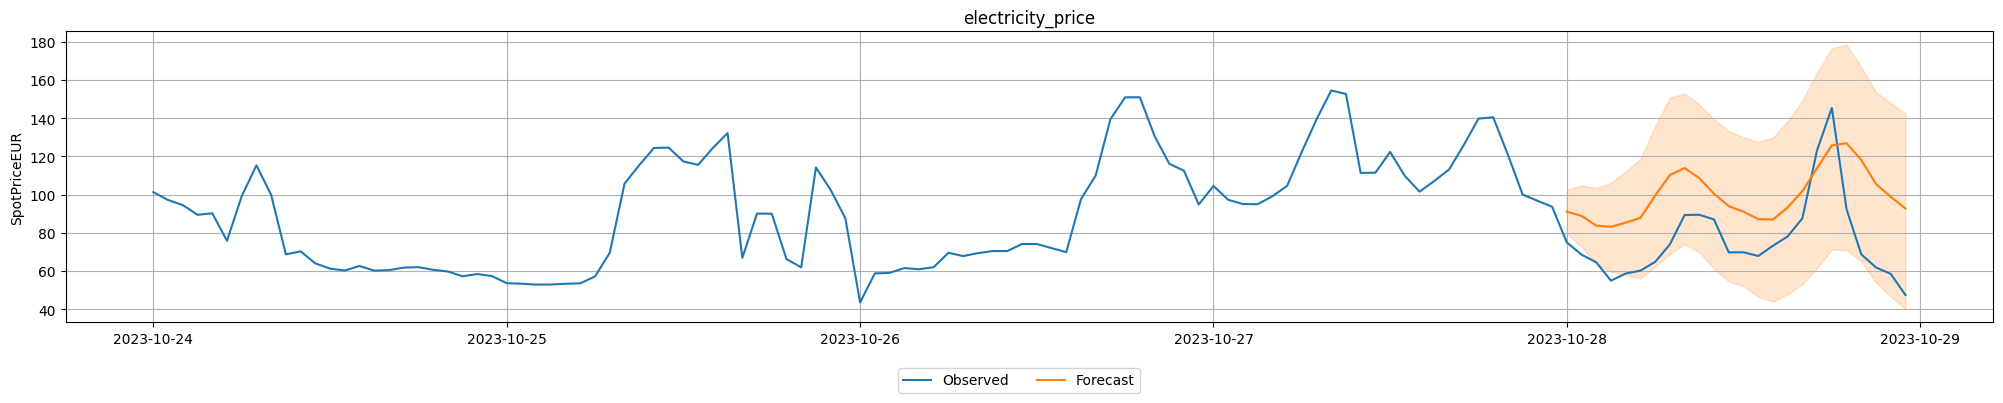

In [92]:
import matplotlib.pyplot as plt
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=24*5, max_num_item_ids=4)

In [93]:
# The test score is computed using the last
# prediction_length=24 timesteps of each time series in test_data
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,DynamicOptimizedTheta,-0.546329,-1.021621,24.449387,21.316176,0.018358,5
1,RecursiveTabular,-0.588725,-0.667390,1.615052,0.942549,4.088618,2
2,TemporalFusionTransformer,-0.597587,-0.640306,0.088604,0.024255,101.406396,8
3,AutoETS,-0.624635,-0.653207,3.397140,3.086112,0.034894,6
4,DirectTabular,-0.639570,-1.252926,0.174281,0.176100,1.507741,3
5,NPTS,-0.701962,-1.034654,2.265295,2.024948,0.013543,4
6,TiDE,-0.776039,-0.498707,0.081963,0.028492,148.102486,11
7,WeightedEnsemble,-0.778508,-0.284405,2.653403,1.992041,0.369028,12
8,ChronosZeroShot[bolt_base],-0.785675,-0.497512,0.983407,1.032264,0.014083,7
9,PatchTST,-0.855713,-0.330568,0.053436,0.017228,44.380254,10


data with frequency 'None' has been resampled to frequency 'h'.


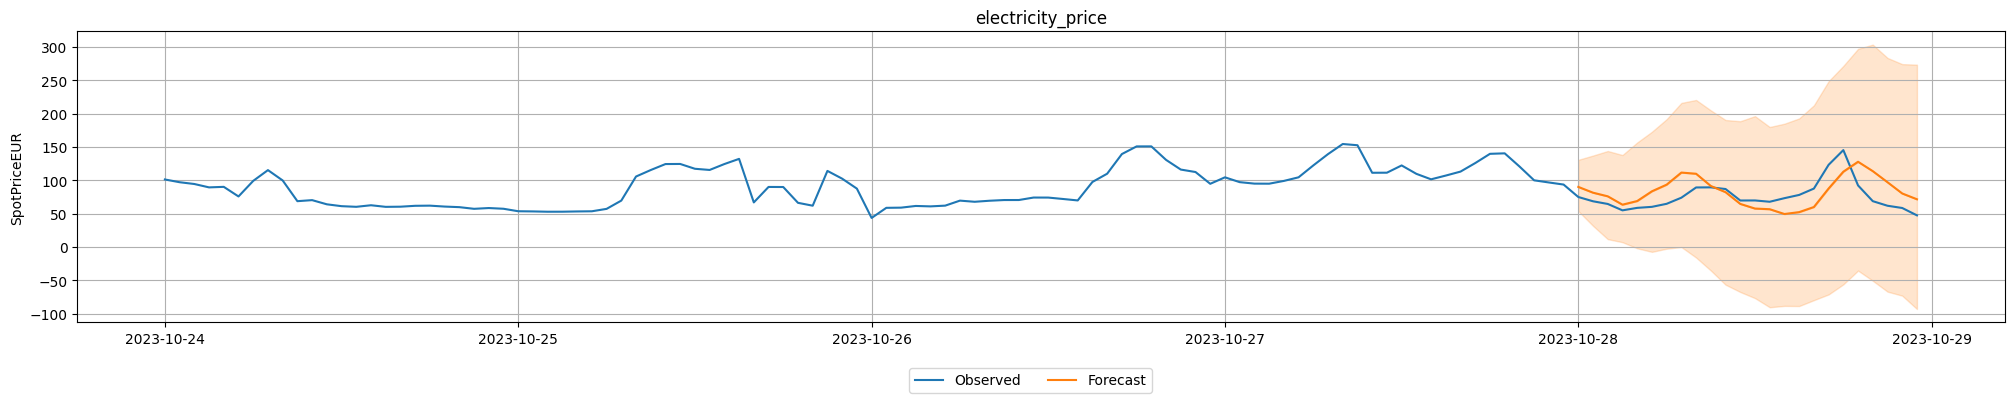

In [95]:
predictions = predictor.predict(train_data, model='DynamicOptimizedTheta')
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=24*5, max_num_item_ids=4)
